# <center>Simulating Quantum Circuit with Qiskit</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pconstantinides/tuc-ieeesb-qtech/blob/main/qc_quickstart/simulating_quantum_computers.ipynb)

In [ ]:
# Uncomment the following to install required libraries
# !pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc -q

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_histogram

### Table of Contents

1. A simple quantum circuit
2. Ideal simulation
3. Noisy simulation
4. Your first algorithm: the spooky AC/DC inverter
5. Analytical exercise

# Generate a three-qubit GHZ state using Qiskit

The Greenberger–Horne–Zeilinger (GHZ) state is the extension to three (or more) qubits to the maximally entangled state characteristic of the Bell state depicted above. That means that the GHZ state is:

$$
|GHZ\rangle = \frac{|000\rangle+|111\rangle}{\sqrt{2}}.
$$

One of the interesting features of the GHZ state is that there are different and equivalent ways to build it using a quantum circuit. In Exercise 1 you will do it in one of the most common ways.


<a id="Exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1: Design a GHZ state</b>

In this exercise, you are asked to implement a [GHZ](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) quantum state, defined as

$$
|GHZ\rangle = \frac{|000\rangle + |111\rangle}{\sqrt{2}}
$$

</div>

>The IBMs __circuit composer__ is an educational tool to familiarize you with quantum circuits. Feel free to use it [here](https://quantum.cloud.ibm.com/composer).

In [ ]:
def ghz_circuit():
  qc = QuantumCircuit(3)

  #####################
  # Add your code here
  #####################
  return qc

ghz = ghz_circuit()
ghz.measure_active()
ghz.draw("mpl")

In [ ]:
def run_circuit(circuit, shots=1000, noise_model=None):
  """
  Executes a quantum circuit many times.

  Parameters:
    circuit (QuantumCircuit): the quantum circuit to simulate.
    shots (int): the number of times to run the circuit.
    noise_model (NoiseModel): An optional noise model to simulate.

  Returns:
    counts (dict): A the number of times each outcome was measured.
  """
  sim = AerSimulator(noise_model=noise_model)

  if noise_model:
    circuit = transpile(circuit, sim)

  result = sim.run(circuit, shots=shots).result()
  counts = result.get_counts()
  return counts

In [ ]:
#################################################
#  counts = # Execute the GHZ circuit many times
#################################################

plot_histogram(counts)

In [ ]:
ghz.remove_final_measurements()
ghz.save_statevector() # requires qiskit-aer

sim = AerSimulator(method="statevector")

result = sim.run(ghz).result()

In [ ]:
statevector = result.get_statevector()

array_to_latex(statevector)

In [ ]:
from qiskit import transpile
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error


##############################################################
# ghz = # Create a new GHZ circuit and measure all the qubits
##############################################################


# Define the probabilities for each type of error
p_gate1 = 0.03
p_gate2 = 0.05
p_meas = 0.04

# QuantumError objects
error_meas = pauli_error([("X", p_meas/2), ("Z", p_meas/2), ("I", 1 - p_meas)])
error_gate1 = pauli_error([("X", p_gate1/2), ("Z", p_gate1/2), ("I", 1 - p_gate1)])
error_gate2 = pauli_error([("XX", p_gate2/2), ("ZZ", p_gate2/2), ("II", 1 - p_gate2)])

# Add errors to noise model
n_model = NoiseModel()
n_model.add_all_qubit_quantum_error(error_meas, "measure")
n_model.add_all_qubit_quantum_error(error_gate1, ["H"])
n_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Run and get counts
noisy_counts = run_circuit(ghz, noise_model=n_model)

# Plot noisy output
plot_histogram(noisy_counts)

## The Qiskit Ecosystem

It's an open-source collection of python libraries used for research and development in the areas of quantum science and technology.

See the official list [here](https://www.ibm.com/quantum/ecosystem).

Many of the projects are community-maintained and thus aren't in best shape, or they might be in a very early stage.

---
## Your First Quantum Algorithm

Suppose you are at an electronics lab and your are given the integrated circuit of an AC/DC inverter. You are asked to check if the device is faulty or functional.

- An AC/DC inverter is *functional* if it always outputs a DC signal.
- The inverter is *faulty* if for one input outputs DC and for the other input it gives AC. Regardless which input gives what.

Here is an illustration for a functional inverter...

<center>
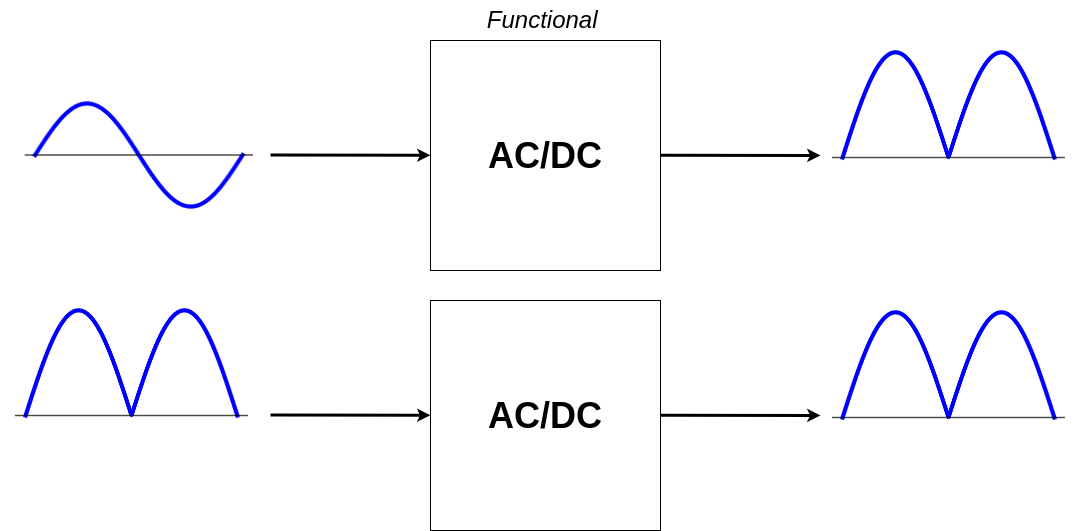
</center>

A "algorithm" would require to check the output for both input cases, thus performing two tests.

---

The actual inverter isn't a valid quantum operation. We need to encapsulate it's action into a quantum gate (unitary).

$$
f_\text{inv}(x) = \begin{cases} 0&\quad\text{if x = functional,}\\1&\quad\text{if x = faulty}\end{cases}
$$

<center>
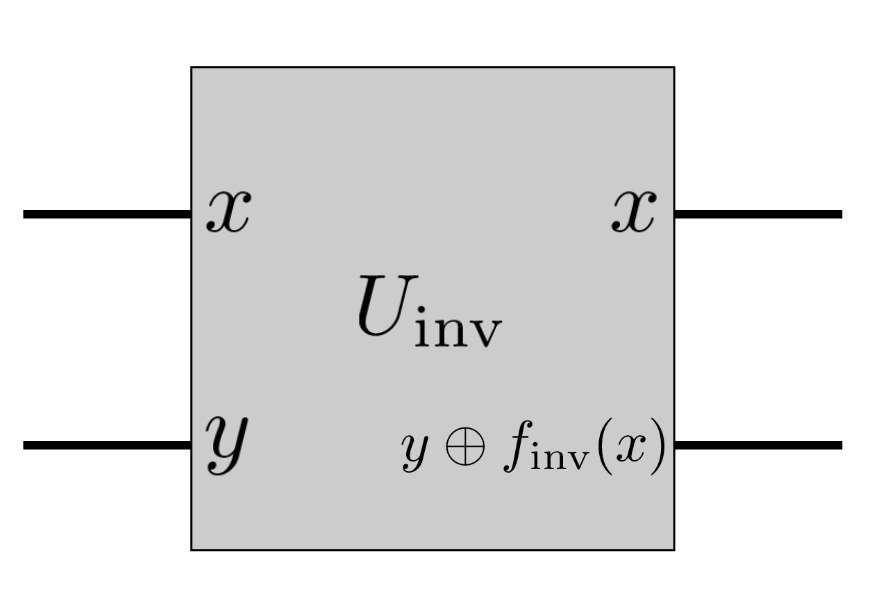
</center>

In [ ]:
from random import choice
from qiskit.circuit.library import UnitaryGate, CXGate
from numpy import identity

def quantum_inverter():
    """
    Generates a two-qubit (bipartite) unitary which leaves the first qubits intact and adds f(x) (mod2) to the second.

    Encoding:
        0 functional
        1 faulty
    """

    inv_type = choice(("functional", "faulty"))    
    label = r"$U_\text{inv}$"
    
    if inv_type == "functional":
        return UnitaryGate(identity(4), label=label), inv_type
    else:
        return UnitaryGate(CXGate(), label=label), inv_type

In [ ]:
qc = QuantumCircuit(2, 1)
u, inv_type = quantum_inverter()

# qc.initialize([0, 0, 1, 0])
qc.x(1)
qc.barrier()

qc.h([0,1])
qc.compose(u, inplace=True)
qc.h(0)
qc.measure([0], [0])

qc.draw('mpl')

In [ ]:
run_circuit(qc, shots=1)

In [ ]:
inv_type

---
## Exercise: there are two independent variables in a qubit

Show that a general qubit 
$$
\begin{aligned}
|\psi\rangle &= a|0\rangle + b|1\rangle, \\[1em]
\text{where} \quad &a, b \in \mathbb{C} \quad \text{and} \quad |a|^2 + |b|^2 = 1
\end{aligned}
$$


can be written equivalently as
$$
|\psi\rangle = \cos(\theta)\space|0\rangle + \cos(\theta)e^{i\phi}\space|1\rangle \quad \text{with}\quad \theta,\space \phi\in\mathbb{R}.
$$

__*Remark*__: since $a$ and $b$ are complex numbers, at first it seems that the qubit is described by four __degrees of freedom__ (aka independent variables) but you can prove that there only two of them: polar and azimuthal ([Bloch ball](https://en.wikipedia.org/wiki/Bloch_sphere)).

<details>
<summary><b>Solution</b></summary>

Both $a$ and $b$ are written in the polar form as
$$
a = Ae^{i\theta}\quad \text{and}\quad b = Be^{i\phi}
$$
by utilizing the irrelevance of the global phase we get
$$
|\psi\rangle = e^{i\theta}\left(A|0\rangle + Be^{i(\phi-\theta)}|1\rangle\right).
$$

From the normalization constraint $A^2 + B^2 = 1$, there exists some real $\tilde{\theta}$ such that
$$
\begin{align*}
&\cos(\tilde{\theta}) = A\\[0.5em]
\text{and}\quad & \sin(\tilde{\theta}) = B
\end{align*}
$$

By substituting we derive the relation of the excercise
$$
|\psi\rangle = \cos(\tilde{\theta})\space|0\rangle + \cos(\tilde{\theta})e^{i\tilde{\phi}}\space|1\rangle
\quad\text{with}\quad \tilde{\phi}=\phi-\theta.
$$
</details>

---

__Qiskit version__: `2.1.2`

__Qiskit-Aer version__: `0.17.2`